In [1]:
%matplotlib notebook
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import torch
from torch.profiler import record_function
from torch_geometric.nn.resolver import aggregation_resolver as aggr_resolver
import numpy as np


# Timing function for performance evaluation
import time
class catchtime:    
    def __init__(self, arg = 'Unnamed Context'):
#         print('__init__ called with', arg)
        self.context = arg
        
    def __enter__(self):
        self.time = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = time.perf_counter() - self.time
        self.readout = f'{self.context} took: {1000 * self.time:.3f} ms'
        print(self.readout)

# Math/parallelization library includes
import numpy as np
import torch

# Imports for neighborhood searches later on
from torch_geometric.nn import radius
from torch_scatter import scatter


# Plotting includes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.tri as tri
import random

from tqdm.notebook import tqdm

In [374]:

from scipy.interpolate import RegularGridInterpolator  
import numpy as np


def interpolant(t):
    return t*t*t*(t*(t*6 - 15) + 10)


def generate_perlin_noise_2d(
        shape, res, tileable=(False, False), interpolant=interpolant, rng = np.random.default_rng(seed=42)
):
    """Generate a 2D numpy array of perlin noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multple of res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            res.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of shape shape with the generated noise.

    Raises:
        ValueError: If shape is not a multiple of res.
    """
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]]\
             .transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*rng.random((res[0]+1, res[1]+1))
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    if tileable[0]:
        gradients[-1,:] = gradients[0,:]
    if tileable[1]:
        gradients[:,-1] = gradients[:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1)
    g00 = gradients[    :-d[0],    :-d[1]]
    g10 = gradients[d[0]:     ,    :-d[1]]
    g01 = gradients[    :-d[0],d[1]:     ]
    g11 = gradients[d[0]:     ,d[1]:     ]
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = interpolant(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)


def generate_fractal_noise_2d(
        shape, res, octaves=1, persistence=0.5,
        lacunarity=2, tileable=(False, False),
        interpolant=interpolant, seed = 1337
):
    """Generate a 2D numpy array of fractal noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multiple of lacunarity**(octaves-1)*res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            (lacunarity**(octaves-1)*res).
        octaves: The number of octaves in the noise. Defaults to 1.
        persistence: The scaling factor between two octaves.
        lacunarity: The frequency factor between two octaves.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The, interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of fractal noise and of shape shape generated by
        combining several octaves of perlin noise.

    Raises:
        ValueError: If shape is not a multiple of
            (lacunarity**(octaves-1)*res).
    """
    rng = np.random.default_rng(seed=seed)
    
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(
            shape, (frequency*res[0], frequency*res[1]), tileable, interpolant, rng
        )
        frequency *= lacunarity
        amplitude *= persistence
    return noise

def generate1DPeriodicNoise(numSamples = 1024, r = 0.75, freq = 4, octaves = 2, persistence = 0.75, lacunarity = 2, plot = False, seed = 1337):
    n = 1024
    # freq = 4
    # octaves = 2
    # persistence = 0.75
    # lacunarity = 2
    noise = generate_fractal_noise_2d([n, n], [freq,freq], octaves, persistence = persistence, lacunarity = lacunarity, seed = seed)

    interp = RegularGridInterpolator((np.linspace(-1,1,n), np.linspace(-1,1,n)), noise)


#     r = 0.75
    # numSamples = 128
    thetas = np.linspace(0, 2 * np.pi, numSamples)

    x = np.cos(thetas) * r
    y = np.sin(thetas) * r

    sampled = interp(np.vstack((x,y)).transpose())
    if plot:
        fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

        circle1 = plt.Circle((0, 0), r, color='white', ls = '--', fill = False)
        axis[0,0].imshow(noise, extent =(-1,1,-1,1))
        axis[0,0].add_patch(circle1)
        axis[0,1].plot(thetas, sampled)

        fig.tight_layout()
    return sampled


def generate1DNoise(numSamples = 1024, r = 1 / (2 * np.pi), freq = 4, octaves = 2, persistence = 0.75, lacunarity = 2, plot = False, seed = 1337):
    n = 1024
    # freq = 4
    # octaves = 2
    # persistence = 0.75
    # lacunarity = 2
    noise = generate_fractal_noise_2d([n, n], [freq, freq], octaves, persistence = persistence, lacunarity = lacunarity, seed = seed)

    interp = RegularGridInterpolator((np.linspace(-1,1,n), np.linspace(-1,1,n)), noise)


#     r = 0.75
    # numSamples = 128
    thetas = np.linspace(0, 2 * np.pi, numSamples)

    x = np.linspace(-1,1,numSamples)
    y = np.zeros(numSamples)

    sampled = interp(np.vstack((x,y)).transpose())
    if plot:
        fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

        circle1 = plt.Circle((0, 0), r, color='white', ls = '--', fill = False)
        axis[0,0].imshow(noise, extent =(-1,1,-1,1))
        axis[0,0].add_patch(circle1)
        axis[0,1].plot(thetas, sampled)

        fig.tight_layout()
    return sampled


In [350]:


def getSpacing(n, periodic = False):
    if n == 1:
        return 2.
    else:
        return 2. / n if periodic else 2./(n-1)


centroidCache = {False:{'cuda':{},'cpu':{}},True:{'cuda':{},'cpu':{}}}
def getDistances(n, x, periodic = False):
    if n in centroidCache[periodic][x.device.type]:
        centroids = centroidCache[periodic][x.device.type][n]
        if periodic:
            spacing = getSpacing(n, True)
            offset = -1 + spacing / 2.
            ra = torch.unsqueeze(x,axis=0) - centroids
            rb = torch.unsqueeze(x,axis=0) - centroids - 2.
            rc = torch.unsqueeze(x,axis=0) - centroids + 2.
            return torch.minimum(torch.minimum(torch.abs(ra)/spacing, torch.abs(rb)/spacing), torch.abs(rc)/spacing)
        else:
            spacing = getSpacing(n, False)
            
            # centroids = torch.linspace(-1.,1.,n, device = x.device) if n > 1 else torch.constant([0.], device = x.device)
        #     tx = torch.constant(x, dtype='float32')
            r = torch.unsqueeze(x,axis=0) - centroids
            return torch.abs(r)  / spacing


    if periodic:
        spacing = getSpacing(n, True)
        offset = -1 + spacing / 2.
        
#         tx = torch.constant(x, dtype='float32')
        centroids = torch.unsqueeze(torch.linspace(-1.,1.,n+1, device = x.device)[:n],axis=1)
        centroidCache[periodic][x.device.type][n] = centroids

        ra = torch.unsqueeze(x,axis=0) - centroids
        rb = torch.unsqueeze(x,axis=0) - centroids - 2.
        rc = torch.unsqueeze(x,axis=0) - centroids + 2.
        return torch.minimum(torch.minimum(torch.abs(ra)/spacing, torch.abs(rb)/spacing), torch.abs(rc)/spacing)
        
    spacing = getSpacing(n, False)
    
    centroids = torch.linspace(-1.,1.,n, device = x.device) if n > 1 else torch.tensor([0.], device = x.device)
    centroids = torch.unsqueeze(centroids, axis = 1)
    centroidCache[periodic][x.device.type][n] = centroids
#     tx = torch.constant(x, dtype='float32')
    r = torch.unsqueeze(x,axis=0) - centroids
    return torch.abs(r)  / spacing


def evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = False):    

    k = int(epsilon)
    r = getDistances(n, x, periodic)    
    if n == 1:
        return torch.ones_like(r)
    
    cpow = lambda x, p: torch.maximum(x, torch.zeros_like(r))**p
    
    funLib = {
        'linear': lambda r:  torch.clamp(1. - r / epsilon,0,1),
        'gaussian': lambda r:  torch.exp(-(epsilon * r)**2),
        'multiquadric': lambda r: torch.sqrt(1. + (epsilon * r) **2),
        'inverse_quadric': lambda r: 1. / ( 1 + (epsilon * r) **2),
        'inverse_multiquadric': lambda r: 1. / torch.sqrt(1. + (epsilon * r) **2),
        'polyharmonic': lambda r: torch.pow(r, k) if k % 2 == 1 else torch.pow(r,k-1) * torch.math.log(torch.pow(r,r)),
        'bump': lambda r: torch.where(r < 1./epsilon, torch.exp(-1./(1- (epsilon * r)**2)), torch.zeros_like(r)),
        'cubic_spline': lambda r: cpow(1-r/epsilon,3) - 4. * cpow(1/2-r/epsilon,3),
        'quartic_spline': lambda r: cpow(1-r/epsilon,4) - 5 * cpow(3/5-r/epsilon,4) + 10 * cpow(1/5-r/epsilon,4),
        'quintic_spline': lambda r: cpow(1-r/epsilon,5) - 6 * cpow(2/3-r/epsilon,5) + 15 * cpow(1/3-r/epsilon,5),
        'wendland2': lambda r: cpow(1 - r/epsilon, 4) * (1 + 4 * r/epsilon),
        'wendland4': lambda r: cpow(1 - r/epsilon, 6) * (1 + 6 * r/epsilon + 35/3 * (r/epsilon)**2),
        'wendland6': lambda r: cpow(1 - r/epsilon, 8) * (1 + 8 * r/epsilon + 25 * (r/epsilon) **2 + 32 * (r/epsilon)**3),
        'poly6': lambda r: cpow(1 - (r/epsilon)**2, 3),
        'spiky': lambda r: cpow(1 - r/epsilon, 3),
        'square': lambda r: torch.where(r <= epsilon, torch.ones_like(r), torch.zeros_like(r))
    }
    rbf = funLib[which]
    
#     if periodic:
#         return torch.maximum(rbf(r[0]), torch.maximum(rbf(r[1]), rbf(r[2])))
        # return torch.clip_by_value(torch.maximum(rbf(r[0]), torch.maximum(rbf(r[1]), rbf(r[2]))),0,1)   
    return rbf(r)#torch.clip_by_value(rbf(r),0,1)
    
def evalChebSeries(n,x):
    cs = []
    for i in range(n):
        if i == 0:
            cs.append(torch.ones_like(x))
        elif i == 1:
            cs.append(x)
        else:
            cs.append(2. * x * cs[i-1] - cs[i-2])
    return torch.stack(cs)
sqrt_pi_1 = 1. / np.sqrt(np.pi)

def fourier(n, x):
    if n == 0:
        return torch.ones_like(x) / np.sqrt(2. * np.pi)
    elif n % 2 == 0:
        return torch.cos((n // 2 + 1) * x) * sqrt_pi_1
    return torch.sin((n // 2 + 1) * x) * sqrt_pi_1

def evalFourierSeries(n, x):
    fs = []
    for i in range(n):
        fs.append(fourier(i, x))
    return torch.stack(fs)

def evalBasisFunction(n, x, which = 'chebyshev', periodic = False):   
    s = which.split()    
#     print(s)
    if s[0] == 'chebyshev':
        return evalChebSeries(n, x)
    if s[0] == 'fourier':
        return evalFourierSeries(n, x * np.pi)
    if s[0] == 'linear':
        return evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = periodic)        
    if s[0] == 'rbf':
        eps = 1. if len(s) < 3 else float(s[2])
        return evalRBFSeries(n, x, which = s[1], epsilon = eps, periodic = periodic)

    
def getWindowFunction(windowFunction):
    windowFn = None
    if windowFunction == 'cubicSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 - 4 * torch.clamp(1/2 - r, min = 0) ** 3
    if windowFunction == 'quarticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 - 5 * torch.clamp(3/5 - r, min = 0) ** 4 + 10 * torch.clamp(1/5- r, min = 0) ** 4
    if windowFunction == 'quinticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 - 6 * torch.clamp(2/3 - r, min = 0) ** 5 + 15 * torch.clamp(1/3 - r, min = 0) ** 5
    if windowFunction == 'Wendland2_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 * (1 + 3 * r)
    if windowFunction == 'Wendland4_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 * (1 + 5 * r + 8 * r**2)
    if windowFunction == 'Wendland6_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 7 * (1 + 7 * r + 19 * r**2 + 21 * r**3)
    if windowFunction == 'Wendland2':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 * (1 + 4 * r)
    if windowFunction == 'Wendland4':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 6 * (1 + 6 * r + 35/3 * r**2)
    if windowFunction == 'Wendland6':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 8 * (1 + 8 * r + 25 * r**2 + 32 * r**3)
    if windowFunction == 'Hoct4':
        def hoct4(x):
            alpha = 0.0927 # Subject to 0 = (1 − α)** nk−2 + A(γ − α)**nk−2 + B(β − α)**nk−2
            beta = 0.5 # Free parameter
            gamma = 0.75 # Free parameter
            nk = 4 # order of kernel

            A = (1 - beta**2) / (gamma ** (nk - 3) * (gamma ** 2 - beta ** 2))
            B = - (1 + A * gamma ** (nk - 1)) / (beta ** (nk - 1))
            P = -nk * (1 - alpha) ** (nk - 1) - nk * A * (gamma - alpha) ** (nk - 1) - nk * B * (beta - alpha) ** (nk - 1)
            Q = (1 - alpha) ** nk + A * (gamma - alpha) ** nk + B * (beta - alpha) ** nk - P * alpha

            termA = P * x + Q
            termB = (1 - x) ** nk + A * (gamma - x) ** nk + B * (beta - x) ** nk
            termC = (1 - x) ** nk + A * (gamma - x) ** nk
            termD = (1 - x) ** nk
            termE = 0 * x

            termA[x > alpha] = 0
            termB[x <= alpha] = 0
            termB[x > beta] = 0
            termC[x <= beta] = 0
            termC[x > gamma] = 0
            termD[x <= gamma] = 0
            termD[x > 1] = 0
            termE[x < 1] = 0

            return termA + termB + termC + termD + termE

        windowFn = lambda r: hoct4(r)
    if windowFunction == 'Spiky':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3
    if windowFunction == 'Mueller':
        windowFn = lambda r: torch.clamp(1 - r ** 2, min = 0) ** 3
    if windowFunction == 'poly6':
        windowFn = lambda r: torch.clamp((1 - r)**3, min = 0)
    if windowFunction == 'Parabola':
        windowFn = lambda r: torch.clamp(1 - r**2, min = 0)
    if windowFunction == 'Linear':
        windowFn = lambda r: torch.clamp(1 - r, min = 0)
    return lambda x: windowFn(x) / windowFn(torch.tensor([0]))

In [3]:
n = 8
basis = 'rbf cubic_spline'
# basis = 'linear'
weights = torch.rand(n) * 2 - 1


<IPython.core.display.Javascript object>


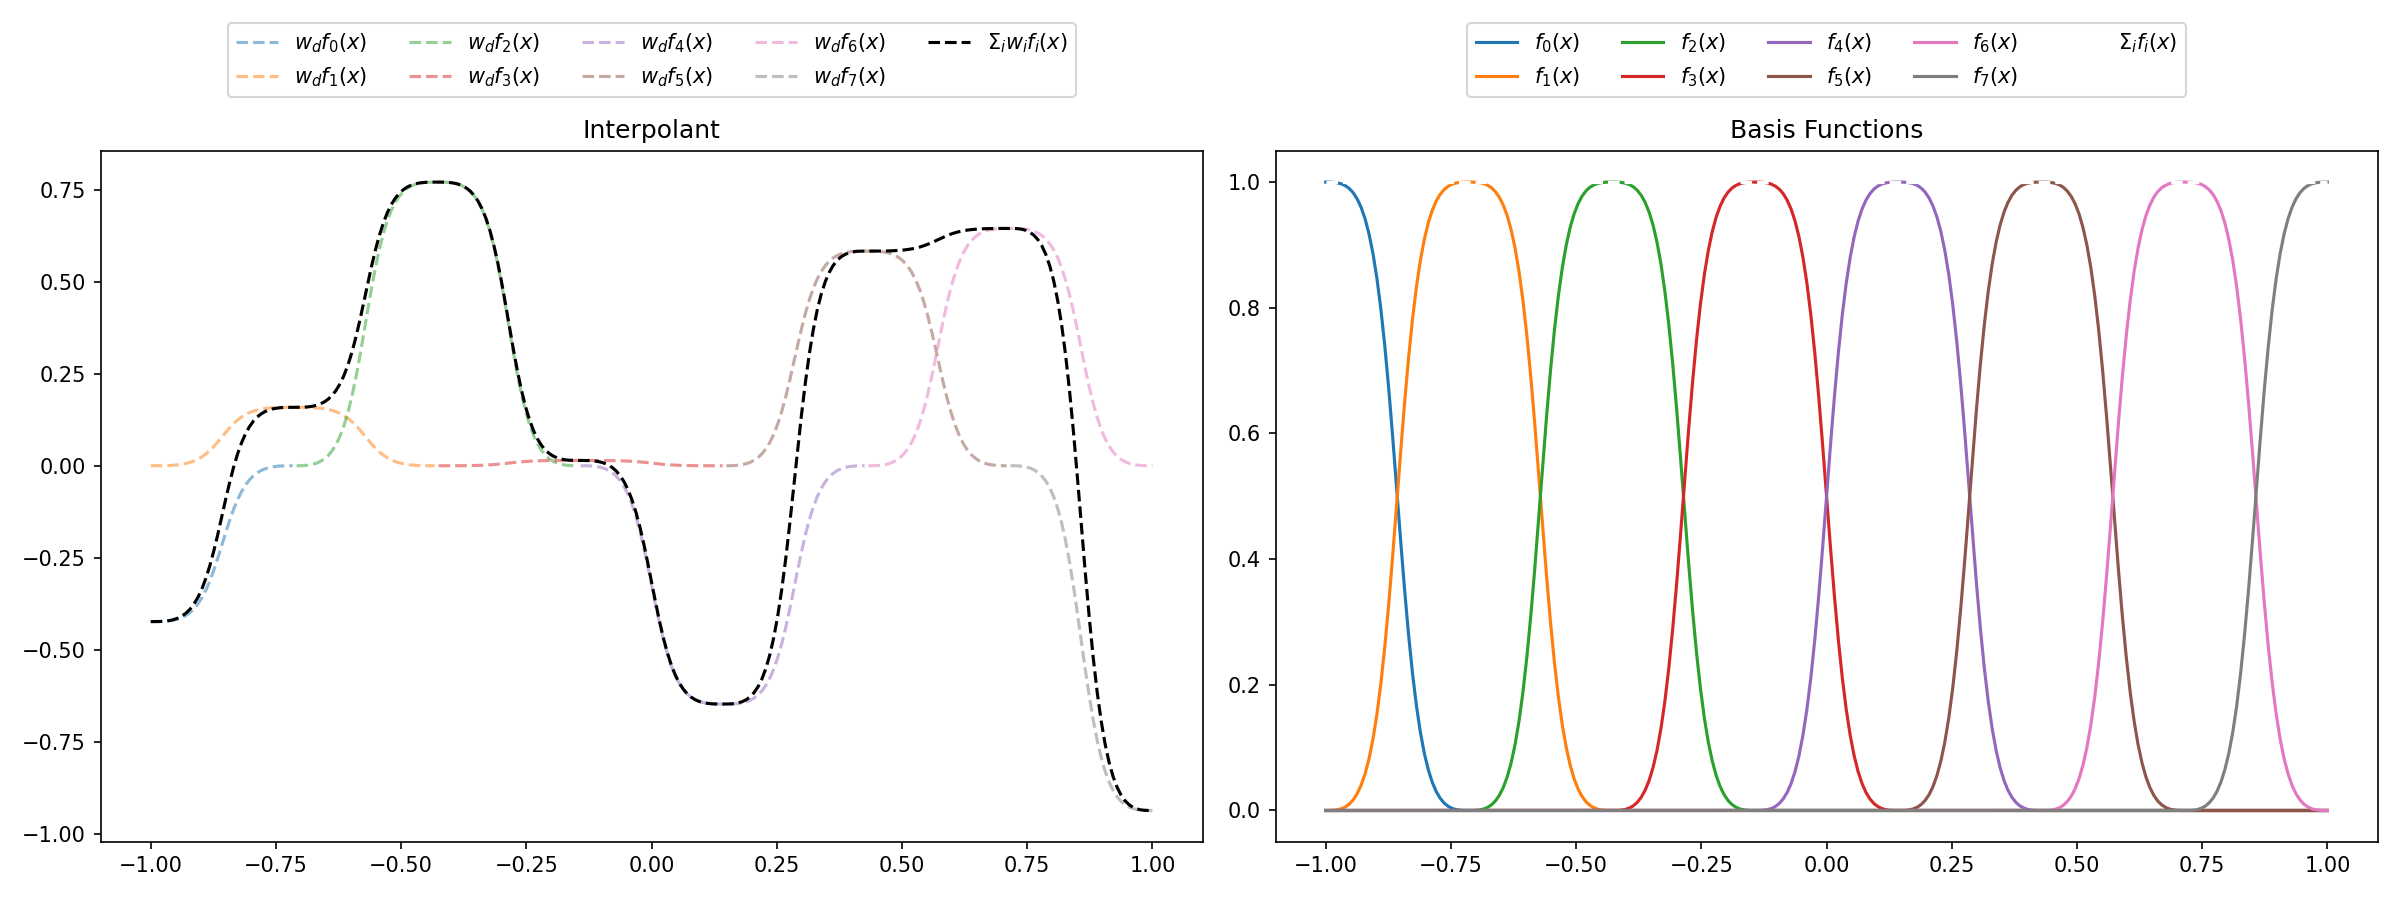

In [4]:

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,255)
fx = evalBasisFunction(n, x , which = basis, periodic=False)
fx = fx / torch.sum(fx, axis = 0)[None,:]

for y in range(n):
#     print(y)
    axis[0,1].plot(x, fx[y,:], label = '$f_%d(x)$' % y)
axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='white', label = '$\Sigma_i f_i(x)$')
# axis[0,0].legend()
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Basis Functions')
# x =  torch.linspace(-1,1,255)
# fx = evalBasisFunction(8, x , which = 'linear', periodic=False)
# fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
for y in range(n):
#     print(y)
    fy = weights[y].detach() * fx[y,:]
    axis[0,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5)
# axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='black', label = '$\Sigma_i f_i(x)$')
axis[0,0].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='black', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,0].legend()
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')
fig.tight_layout()

  0%|          | 0/256 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


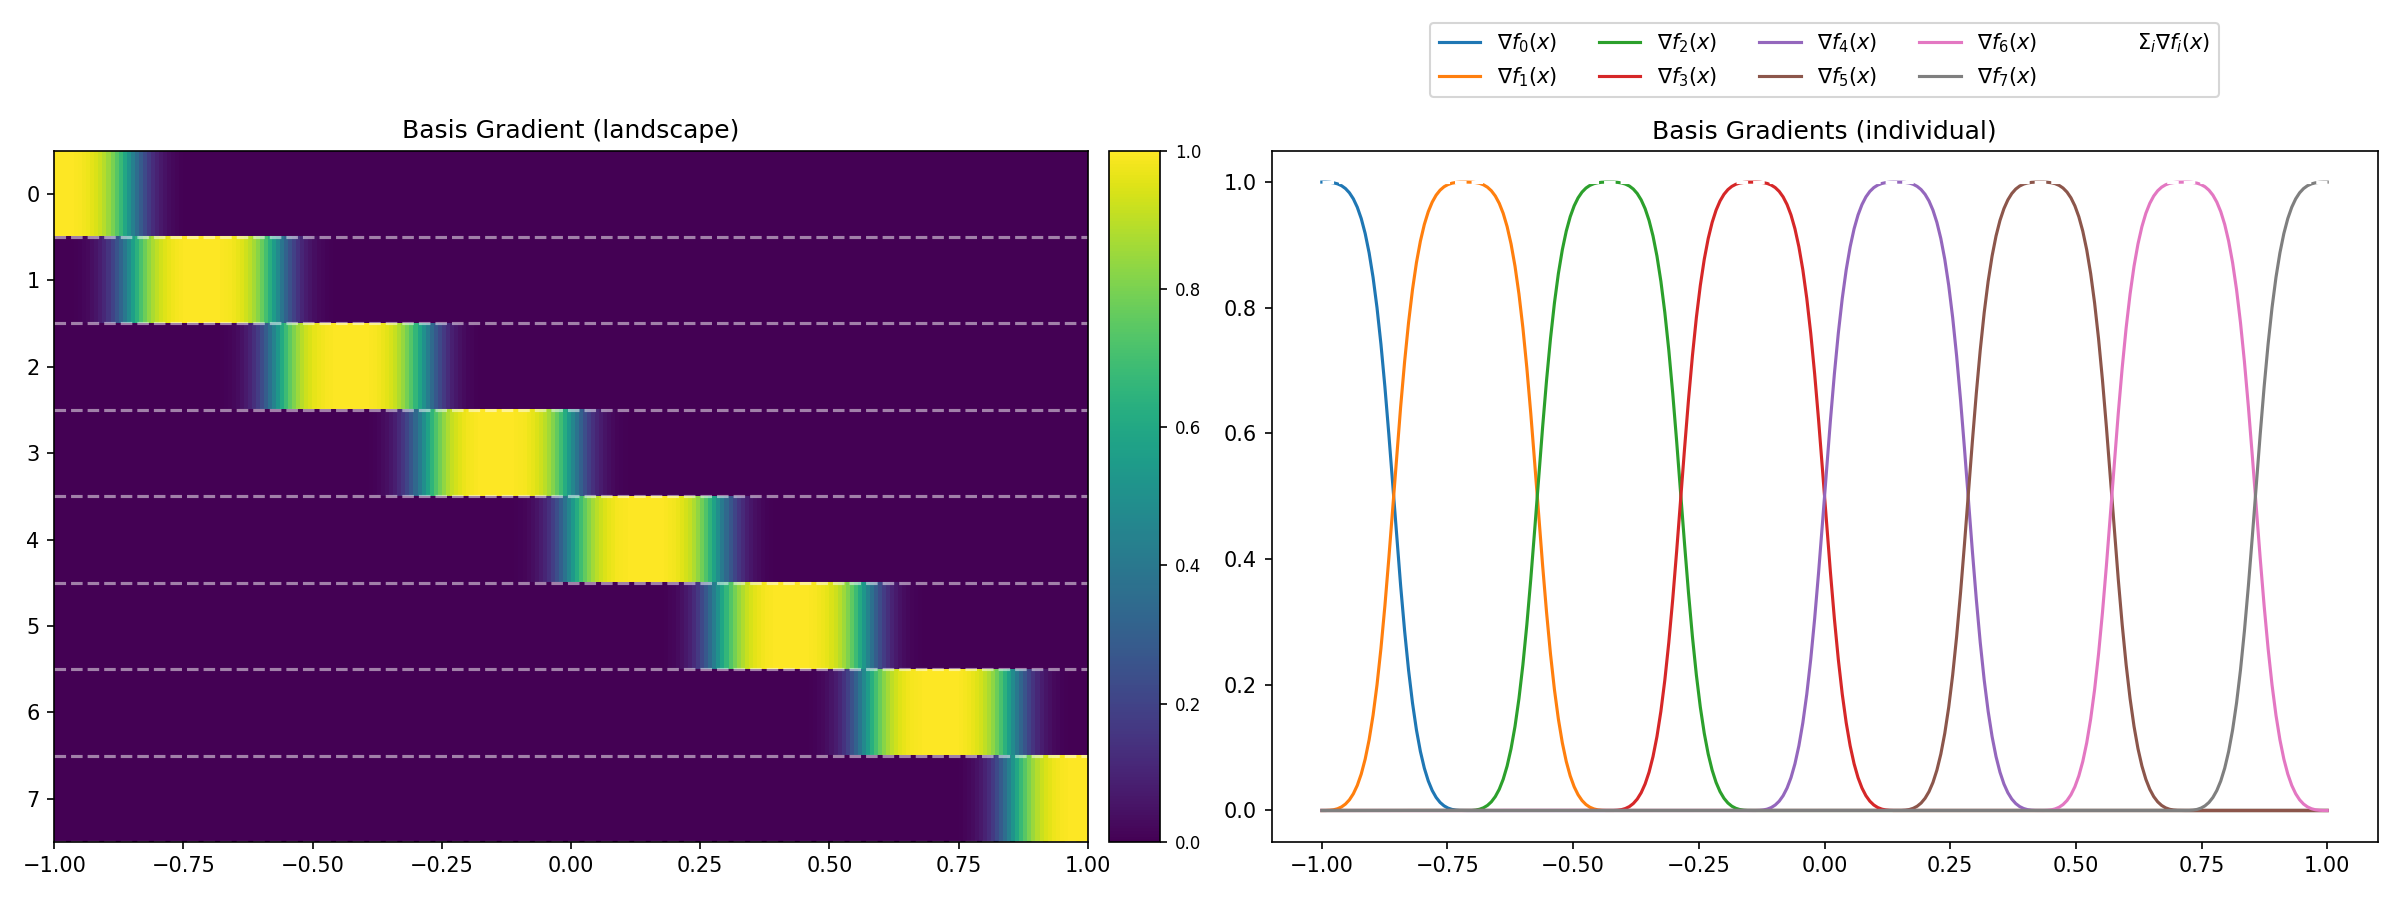

In [11]:
nx = 256
grads = []
for i in tqdm(range(nx)):
    x = torch.tensor([-1 + 2 / (nx - 1) * i], dtype = torch.float32)
    weights.grad = torch.zeros(weights.shape)
    weights.requires_grad = True
    fx = evalBasisFunction(n, x , which = basis, periodic=False)
    fx = fx / torch.sum(fx, axis = 0)[None,:]
    wfx = torch.sum(weights[:,None] * fx, axis = 0)
    wfx.backward()
    grads.append(torch.clone(weights.grad))
grads = torch.vstack(grads)

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

im = axis[0,0].imshow(grads.mT, aspect = 'auto', extent = [-1,1, weights.shape[0],0], interpolation = 'nearest')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
cb1.ax.tick_params(labelsize=8) 

axis[0,0].set_yticks([x + 0.5 for x in range(weights.shape[0])])
axis[0,0].set_yticklabels([x for x in range(weights.shape[0])])
for i in range(weights.shape[0]):
    axis[0,0].axhline(i + 1, ls = '--', alpha = 0.5, c = 'white')
axis[0,0].set_title('Basis Gradient (landscape)')
for y in range(weights.shape[0]):
    axis[0,1].plot(torch.linspace(-1,1,nx), grads[:,y], label = '$\\nabla f_%d(x)$' % y)
axis[0,1].plot(torch.linspace(-1,1,nx), torch.sum(grads,axis=1),ls='--',c='white', label = '$\Sigma_i \\nabla f_i(x)$')
    
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,1].set_title('Basis Gradients (individual)')
fig.tight_layout()

In [13]:
target = lambda x: torch.sin(x * np.pi)

<IPython.core.display.Javascript object>


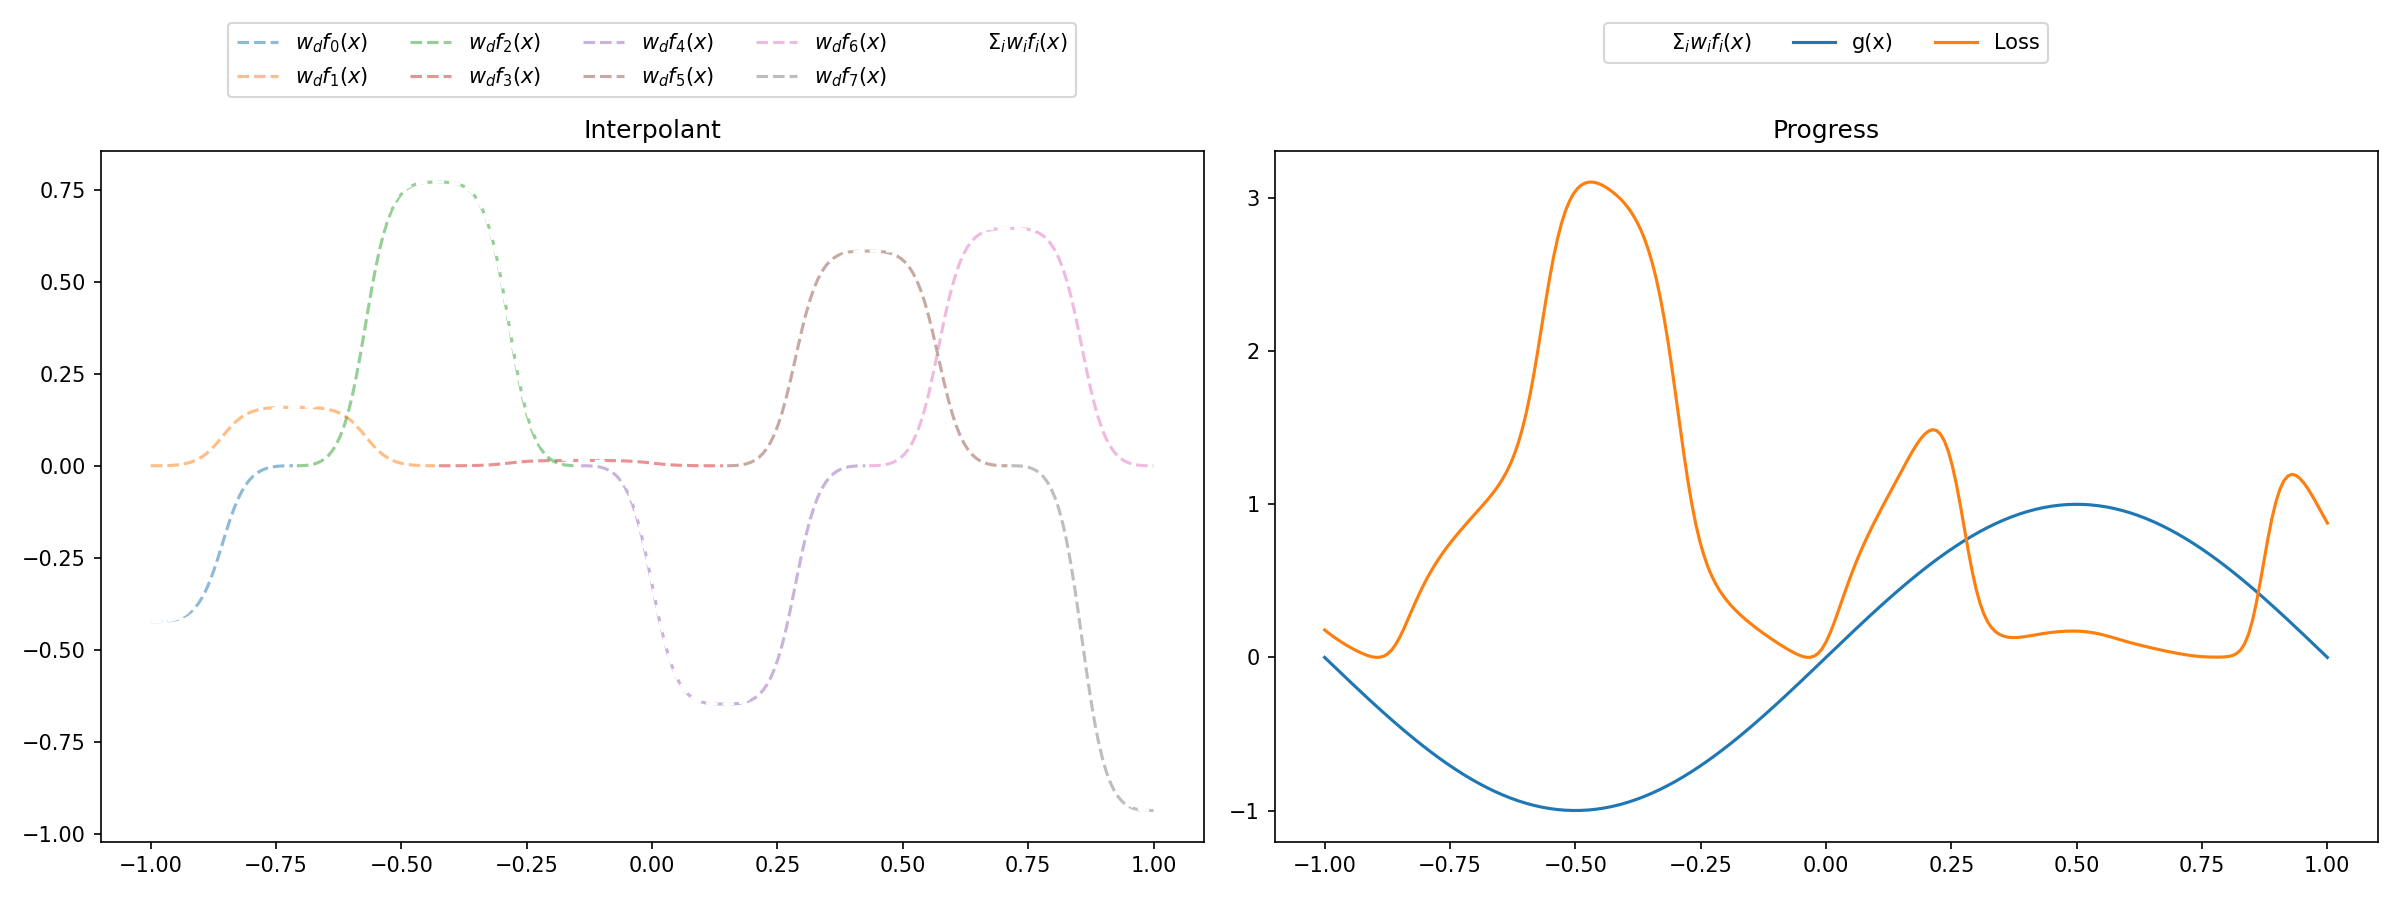

In [14]:

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,255)
fx = evalBasisFunction(n, x , which = basis, periodic=False)
fx = fx / torch.sum(fx, axis = 0)[None,:]


for y in range(n):
#     print(y)
    fy = weights[y].detach() * fx[y,:]
    axis[0,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5)
# axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='black', label = '$\Sigma_i f_i(x)$')
axis[0,0].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='white', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,0].legend()
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')

axis[0,1].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='white', label = '$\Sigma_i w_i f_i(x)$')
axis[0,1].plot(x, target(x),label = 'g(x)')
axis[0,1].plot(x, (torch.sum(weights[:,None].detach() * fx, axis=0) - target(x))**2, label = 'Loss')
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Progress')
fig.tight_layout()

In [15]:
weights.requires_grad = False
weights.grad = torch.zeros(weights.shape)
weights.requires_grad = True
loss = torch.sum((torch.sum(weights[:,None] * fx, axis=0) - target(x))**2)
loss.backward()
print(loss)

tensor(205.8993, grad_fn=<SumBackward0>)


In [16]:
print(weights)
print(torch.sin(torch.linspace(-1,1,32) * np.pi))

tensor([-0.4235,  0.1587,  0.7707,  0.0144, -0.6475,  0.5832,  0.6448, -0.9367],
       requires_grad=True)
tensor([ 8.7423e-08, -2.0130e-01, -3.9436e-01, -5.7127e-01, -7.2479e-01,
        -8.4864e-01, -9.3775e-01, -9.8847e-01, -9.9872e-01, -9.6808e-01,
        -8.9780e-01, -7.9078e-01, -6.5137e-01, -4.8530e-01, -2.9936e-01,
        -1.0117e-01,  1.0117e-01,  2.9936e-01,  4.8530e-01,  6.5137e-01,
         7.9078e-01,  8.9780e-01,  9.6808e-01,  9.9872e-01,  9.8847e-01,
         9.3775e-01,  8.4864e-01,  7.2479e-01,  5.7127e-01,  3.9436e-01,
         2.0130e-01, -8.7423e-08])


In [17]:

import torch.optim as optim

In [194]:
n = 8
basis = 'rbf cubic_spline 2'
# basis = 'linear'
weights = torch.rand(n) * 2 - 1
normalizedBasis = True

x =  torch.linspace(-1,1,255)
def evalBasis(n,x,which, periodic = False, normalized = False):
    fx = evalBasisFunction(n, x , which = which, periodic=periodic)
    if normalized:
        fx = fx / torch.sum(fx, axis=0)
    return fx
fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis)
# fx = evalBasisFunction(n, x , which = basis, periodic=False) if not normalizedBasis else evalBasisFunction(n, x , which = basis, periodic=False) / torch.sum(evalBasisFunction(n, x , which = basis, periodic=False),axis = 0)

In [196]:
weights = torch.rand(n)
# weights = torch.sin(torch.linspace(-1,1,n) * np.pi)
weights.requires_grad = True
optimizer = optim.SGD([weights], lr=1e-2, momentum=0.9)

weightList = []
gradList = []
weightList.append(torch.clone(weights.detach()))

for i in range(256):
    optimizer.zero_grad()

    loss = torch.sum((torch.sum(weights[:,None] * fx, axis=0) - target(x))**2)
    loss.backward()

    gradList.append(torch.clone(weights.grad.detach()))
    optimizer.step()
    weightList.append(torch.clone(weights))

In [24]:
# weightList

In [25]:
# gradList

In [26]:
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']

<IPython.core.display.Javascript object>


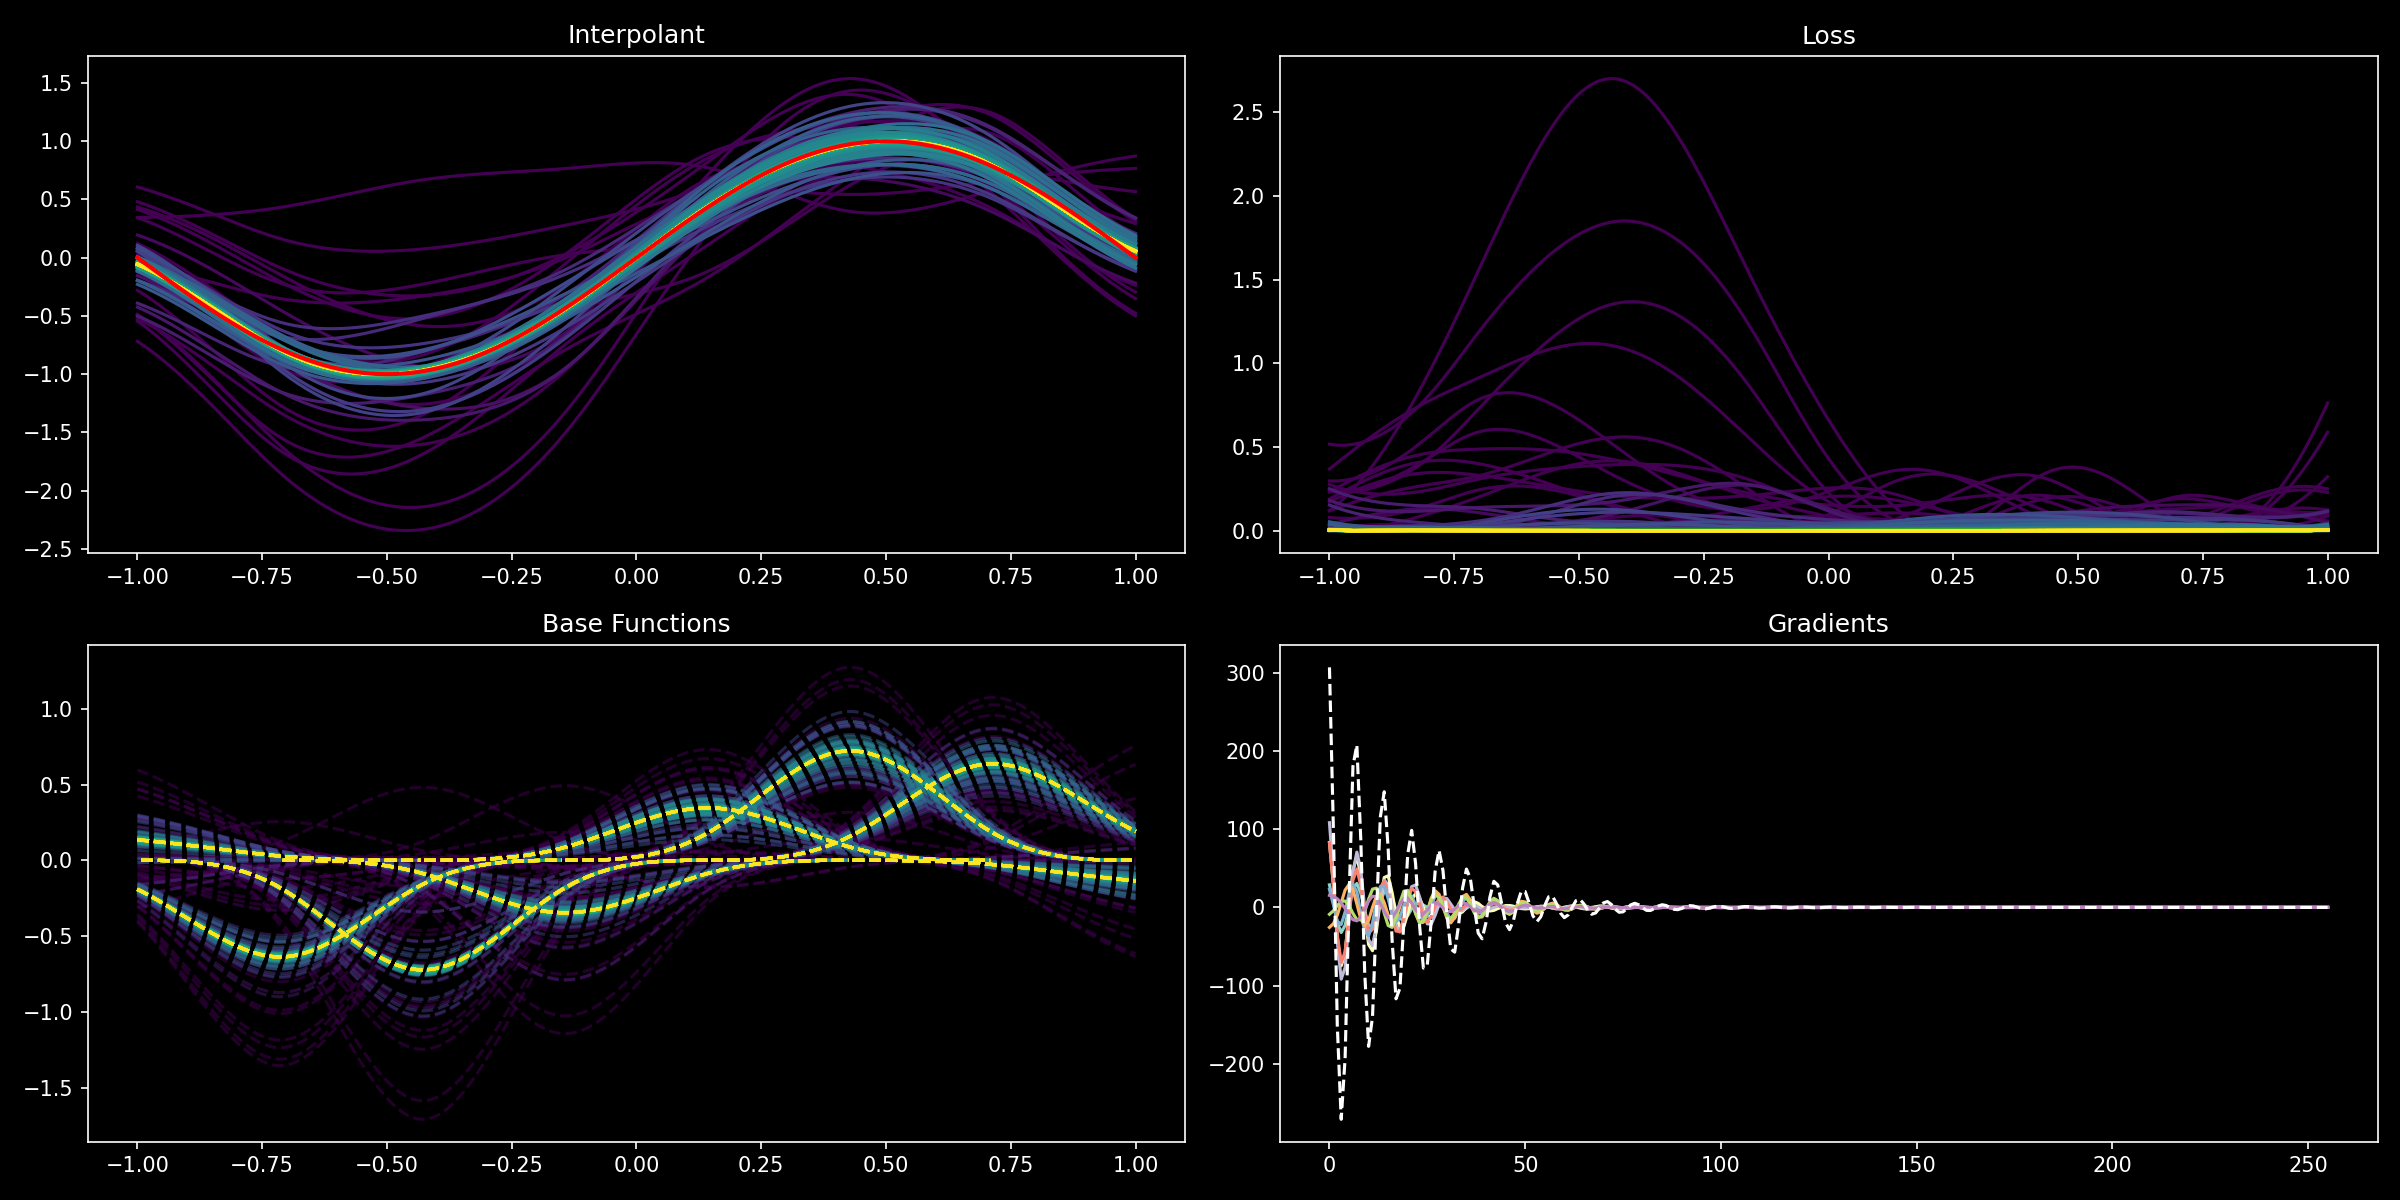

In [197]:

fig, axis = plt.subplots(2, 2, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,255)
fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis)
# fx = evalBasisFunction(n, x , which = basis, periodic=False)
# fx = fx / torch.sum(fx, axis = 0)[None,:]

import matplotlib.colors as colors
norm = colors.LogNorm(vmin=1, vmax=len(weightList))

for i, w in enumerate(weightList):
    c = cmap(-1 + 2 / (len(weightList) - 1)* i)
    c = cmap(norm(i + 1) *2 -1)
    for y in range(n):
        fy = w[y].detach() * fx[y,:]
        axis[1,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5,c = c)
        
    axis[0,0].plot(x,torch.sum(w[:,None].detach() * fx, axis=0),ls='-',c=c, label = 'epoch %d' % i)
    loss = (torch.sum(w.detach()[:,None] * fx, axis=0) - target(x))**2
    axis[0,1].plot(x, loss,c=c)
#     axis[2,0].plot(x,torch.sum(w[:,None].detach() * fx, axis=0),ls='-',c=cmap(-1 + 2 / (len(weightList) - 1)* i), label = '$\Sigma_i w_i f_i(x)$')
    
#     print(w)
    
gradListTensor = torch.vstack(gradList)
for i in range(n):
    axis[1,1].plot(gradListTensor[:,i])
    
axis[1,1].plot(torch.sum(gradListTensor, axis=1), c = 'white', ls = '--')
# for i, g in enumerate(gradList):
#     axis[1,1].scatter(torch.arange(g.shape[0]), g, s = 4,color=cmap(-1 + 2 / (len(weightList) - 1)* i))
    
#     axis[1,1].grid(True)
#     axis[1,1].plot(x, g,c=cmap(-1 + 2 / (len(gradList) - 1)* i))
    
axis[0,0].plot(x, target(x),label = 'target',lw=2,c='red')
    
axis[0,0].set_title('Learning Progress')
axis[0,1].set_title('Loss')
axis[1,0].set_title('Base Functions')
axis[1,1].set_title('Gradients')
# axis[0,0].legend()
# axis[0,0].legend(loc='right', bbox_to_anchor=(1.15, 0.8),
#           ncol=1, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')

# axis[0,1].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='black', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,1].plot(x, target(x),label = 'g(x)')
# axis[0,1].plot(x, (torch.sum(weights[:,None].detach() * fx, axis=0) - target(x))**2, label = 'Loss')
# axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
#           ncol=5, fancybox=True, shadow=False)
# axis[0,1].set_title('Progress')
fig.tight_layout()

In [141]:
def sampleCentered(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    means = torch.linspace(-1,1,n)
    dx = 2 / (n-1)
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, dx / dxScale, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sampleOffCentered(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    means = torch.linspace(-1,1,n)
    means = means[:-1] + torch.diff(means) / 2
    dx = 2 / (n-1)
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, dx / dxScale, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sampleUniform(n, samples, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    sampled = []
    for s in range(samples):
        s = torch.rand(n, generator = generator)
        sampled.append(s *2 - 1)
    return sampled

def sampleNormal(n, samples, dx = 0.125, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    sampled = []
    for s in range(samples):
        s = torch.normal(torch.zeros(n), torch.ones(n) * dx, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sampleCheb1(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    cpts = np.polynomial.chebyshev.chebpts1(n)
    dx = np.diff(cpts)
    dx2 = (dx[:-1] + dx[1:]) / 2
    dx = np.hstack((dx[0], dx2, dx[-1]))
    means = torch.tensor(cpts)
    var = torch.tensor(dx) / dxScale
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, var, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled
def sampleCheb2(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    cpts = np.polynomial.chebyshev.chebpts2(n)
    dx = np.diff(cpts)
    dx2 = (dx[:-1] + dx[1:]) / 2
    dx = np.hstack((dx[0], dx2, dx[-1]))
    means = torch.tensor(cpts)
    var = torch.tensor(dx) / dxScale
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, var, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sample(n, samples, method = 'centered', dxScale = 8, dx = 1/3, clamped = True, seed = None):
    if method == 'centered':
        return sampleCentered(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)
    if method == 'offCentered':
        return sampleOffCentered(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)
    if method == 'uniform':
        return sampleUniform(n, samples, seed = seed)
    if method == 'normal':
        return sampleNormal(n, samples, dx = dx, clamped = clamped, seed = seed)
    if method == 'cheb1':
        return sampleCheb1(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)
    if method == 'cheb2':
        return sampleCheb2(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)

<IPython.core.display.Javascript object>


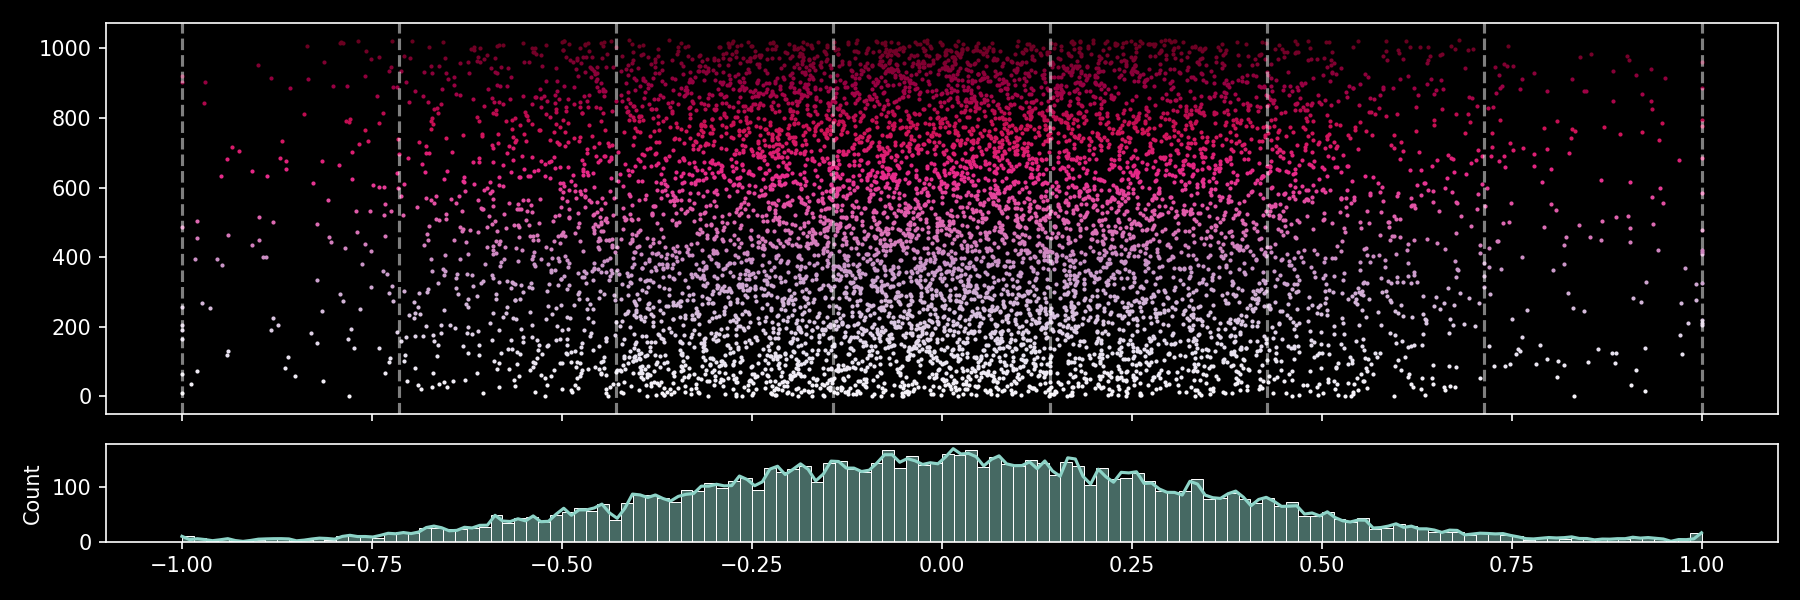

In [277]:

dx = 2 / (n-1)
sampled = sample(n, 1024, method = 'normal', dxScale = 8, dx = 1/3, clamped = True, seed = None)

fig, axis = plt.subplots(2, 1, figsize=(12,4), height_ratios = [4,1], sharex = True, sharey = False, squeeze = False)
for s in range(len(sampled)):
    axis[0,0].scatter(sampled[s],s * torch.ones(sampled[s].shape),ls='-',color=mpl.colormaps['PuRd'](1 / (len(sampled) - 1)* s), label = 'sample %d' % i, s = 1)
    
for i in range(n):
    axis[0,0].axvline(-1 + dx * i, ls = '--', c = 'white', alpha = 0.5)

# axis[1,0].hist(torch.vstack(sampled))
sns.histplot(data = torch.vstack(sampled).flatten(), bins = 128, ax = axis[1,0],kde = True, kde_kws={'bw_adjust':0.1})
fig.tight_layout()

In [707]:
def plotDataset(dataset, samples, target):
    fig, axis = plt.subplots(3, 1, figsize=(12,8), height_ratios = [4,4,1], sharex = True, sharey = False, squeeze = False)

    xb = torch.linspace(-1,1,2048)
    axis[0,0].plot(xb, target(xb), c = 'white',lw = 0.5)

    for s in range(samples):
        axis[0,0].scatter(dataset[s,:],target(dataset[s,:]),ls='-',color=mpl.colormaps['PuRd'](1 / (samples - 1)* s), label = 'sample %d' % s, s = 2)    


    for s in range(samples):
        axis[1,0].scatter(dataset[s,:],s * torch.ones(dataset[s,:].shape),ls='-',color=mpl.colormaps['PuRd'](1 / (samples - 1)* s), label = 'sample %d' % s, s = 1)

    dx = 2 / (n-1)
    for i in range(n):
        axis[0,0].axvline(-1 + dx * i, ls = '--', c = 'white', alpha = 0.5)
        axis[1,0].axvline(-1 + dx * i, ls = '--', c = 'white', alpha = 0.5)

    sns.histplot(data = dataset.flatten(), bins = 128, ax = axis[2,0],kde = True, kde_kws={'bw_adjust':0.1})
    fig.tight_layout()
    
def plotTraining(n, basis, normalizedBasis, target, weightList, gradList):
    fig, axis = plt.subplots(2, 2, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
    x =  torch.linspace(-1,1,255)
    fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis)

    import matplotlib.colors as colors
    norm = colors.LogNorm(vmin=1, vmax=len(weightList))

    for i, w in enumerate(weightList):
        c = cmap(1 / (len(weightList) - 1)* i)
        c = cmap(norm(i + 1))
        for y in range(n):
            fy = w[y].detach() * fx[y,:]
            axis[1,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5,c = c)

        axis[0,0].plot(x,torch.sum(w[:,None].detach() * fx, axis=0),ls='-',c=c, label = 'epoch %d' % i)
        loss = (torch.sum(w.detach()[:,None] * fx, axis=0) - target(x))**2
        axis[0,1].plot(x, loss,c=c)

    gradListTensor = torch.vstack(gradList)
    for i in range(n):
        axis[1,1].plot(gradListTensor[:,i])

    axis[1,1].plot(torch.sum(gradListTensor, axis=1), c = 'white', ls = '--')
    axis[0,0].plot(x, target(x),label = 'target',lw=2,c='red')    
    axis[0,0].set_title('Learning Progress')
    axis[0,1].set_title('Loss')
    axis[1,0].set_title('Base Functions')
    axis[1,1].set_title('Gradients')
    axis[0,0].set_title('Interpolant')
    fig.tight_layout()
    
def plotTrainingv2(n, basis, normalizedBasis, target, weightList, gradList, lossList, plotInterval = 1):
    fig, axis = plt.subplots(1, 2, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
    x =  torch.linspace(-1,1,255)
    fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis)

    import matplotlib.colors as colors
    norm = colors.LogNorm(vmin=1, vmax=len(weightList))
    losses = []
    for i, w in enumerate(weightList):
        c = cmap(1 / (len(weightList) - 1)* i)
        c = cmap(norm(i + 1))
    #     for y in range(n):
    #         fy = w[y].detach() * fx[y,:]
    #         axis[1,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5,c = c)
        if i % plotInterval == 0:
            axis[0,0].plot(x,torch.sum(w[:,None].detach() * fx, axis=0),ls='-',c=c, label = 'epoch %d' % i)
        loss = torch.mean((torch.sum(w.detach()[:,None] * fx, axis=0) - target(x))**2)
        losses.append(loss)
    #     axis[0,1].plot(x, loss,c=c)

    axis[0,1].loglog(torch.hstack(losses), label = 'error')
    axis[0,1].loglog(torch.hstack(lossList), label = 'training loss')
    axis[0,1].legend()

    # gradListTensor = torch.vstack(gradList)
    # for i in range(n):
    #     axis[1,1].plot(gradListTensor[:,i])

    # axis[1,1].plot(torch.sum(gradListTensor, axis=1), c = 'white', ls = '--')
    axis[0,0].plot(x, target(x),label = 'target',lw=2,c='red')    
    axis[0,0].set_title('Learning Progress')
    axis[0,1].set_title('Loss')
    # axis[1,0].set_title('Base Functions')
    # axis[1,1].set_title('Gradients')
    axis[0,0].set_title('Interpolant')
    fig.tight_layout()

In [708]:
from torch_geometric.loader import DataLoader

def generateLoaders(dataset, batch_size = 4, shuffleDataset = True, shuffled = True, shuffleSeed = None):
    if shuffled:
        npGenerator = np.random.default_rng(seed = shuffleSeed)
        t = np.arange(n * len(dataset))
        npGenerator.shuffle(t)

        shuffledDataset = dataset.flatten()[t].reshape(dataset.shape)
        train_dataloader = DataLoader(shuffledDataset, shuffle=shuffleDataset, batch_size = batch_size)
        train_iter = iter(train_dataloader)
        return train_dataloader, train_iter

    train_dataloader = DataLoader(dataset, shuffle=shuffleDataset, batch_size = batch_size)
    train_iter = iter(train_dataloader)
    return train_dataloader, train_iter

def sampleDataLoader():
    global train_dataloder, train_iter
    try:
        bdata = next(train_iter)
    except:
        train_iter = iter(train_dataloader)
        bdata = next(train_iter)
    return bdata

In [709]:
def generateTargetFunction(freq = 4, octaves = 2, seed = 1234, r = 1 / (2 * np.pi), persistence = 0.5, numSamples = 2**16, normalized = True, periodicNoise = True, window = None, baseOverride = None, plot = False):    
#     baseTarget = lambda x: (torch.sin(x * np.pi * 4) + 0.5 * torch.sin(x * np.pi * 2) + 0.25 * torch.sin(x * np.pi)).numpy()
#     baseTarget = lambda x: np.sin( np.pi * 100 * x)

    noise  = generate1DPeriodicNoise(numSamples = numSamples, r = r, freq = freq, octaves = octaves, plot = False, seed = seed, persistence = persistence) if periodicNoise else generate1DNoise(numSamples = numSamples, r = r, freq = freq, octaves = octaves, plot = False, seed = seed, persistence = persistence)
#     noise  = 
    baseTarget = lambda x : np.interp(x, np.linspace(-1,1,numSamples), noise) 
    if baseOverride is not None:
        baseTarget = baseOverride
    if window is not None:
        windowFunc = getWindowFunction(window)
        windowFn = lambda x : windowFunc(torch.abs(torch.tensor(x))).numpy()
        intermediate = lambda x: baseTarget(x) * windowFn(x) 
    else:
        intermediate = lambda x: baseTarget(x)

    xs = np.linspace(-1,1,2**16)
    maxValue = intermediate(xs[np.argmax(np.abs(intermediate(xs)))])

    target = lambda x: intermediate(x) 
    if normalized:
        target = lambda x: intermediate(x) / maxValue
    
#     target = lambda x: intermediate(x) / maxValue
    if plot:
        xs = np.linspace(-1,1,numSamples)
        signal = target(xs)

        fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
        axis[0,0].plot(xs, baseTarget(xs), label = 'baseTarget')
        axis[0,0].plot(xs, windowFn(xs), label = 'window')
        axis[0,0].plot(xs, signal, label = 'target')
        axis[0,0].legend()

        fs = numSamples/2
        fftfreq = np.fft.fftshift(np.fft.fftfreq(xs.shape[-1], 1/fs/1))    
        x = baseTarget(xs)
        y = np.abs(np.fft.fftshift(np.fft.fft(x) / len(x)))
        axis[0,1].semilogx(fftfreq[fftfreq.shape[0]//2:],y[fftfreq.shape[0]//2:], label = 'baseTarget')
        x = windowFn(xs)
        y = np.abs(np.fft.fftshift(np.fft.fft(x) / len(x)))
        axis[0,1].semilogx(fftfreq[fftfreq.shape[0]//2:],y[fftfreq.shape[0]//2:], label = 'window')
        x = target(xs)
        y = np.abs(np.fft.fftshift(np.fft.fft(x) / len(x)))
        axis[0,1].semilogx(fftfreq[fftfreq.shape[0]//2:],y[fftfreq.shape[0]//2:], label = 'target')
        axis[0,1].legend()

        f, Pxx_den = scipy.signal.welch(baseTarget(x), fs, nperseg=len(x)//32)
        axis[0,2].loglog(f, Pxx_den, label = 'baseTarget')
        f, Pxx_den = scipy.signal.welch(windowFn(x), fs, nperseg=len(x)//32)
        axis[0,2].loglog(f, Pxx_den, label = 'window')
        f, Pxx_den = scipy.signal.welch(target(x), fs, nperseg=len(x)//32)
        axis[0,2].loglog(f, Pxx_den, label = 'target')
        axis[0,2].set_xlabel('frequency [Hz]')
        axis[0,2].set_ylabel('PSD [V**2/Hz]')
        axis[0,2].legend()

        fig.tight_layout()
    return target

def evalGroundTruth(samples, dataset, target, noise = True, noiseType = 'normal', noiseVar = 0.1):
    gts = []

    for s in range(samples):
        points = dataset[s]
        gt = target(points)
        if noise:
            if noiseType == 'normal':
                gt = gt + torch.normal(torch.zeros(gt.shape), torch.ones(gt.shape) * noiseVar)
            if noiseType == 'uniform':
                gt = gt + torch.rand(gt.shape) * 2 - 1
        gts.append(gt)
    gts = torch.vstack(gts)
    return gts


def plotDatasetAndGroundtruth(dataset, samples, target, gt):
    fig, axis = plt.subplots(3, 1, figsize=(12,8), height_ratios = [4,4,1], sharex = True, sharey = False, squeeze = False)

    xb = torch.linspace(-1,1,2048)
    axis[0,0].plot(xb, target(xb), c = 'white',lw = 0.5)

    for s in range(samples):
        axis[0,0].scatter(dataset[s,:],gt[s,:],ls='-',color=mpl.colormaps['PuRd'](1 / (samples - 1)* s), label = 'sample %d' % s, s = 2)    


    for s in range(samples):
        axis[1,0].scatter(dataset[s,:],s * torch.ones(dataset[s,:].shape),ls='-',color=mpl.colormaps['PuRd'](1 / (samples - 1)* s), label = 'sample %d' % s, s = 1)

    dx = 2 / (n-1)
    for i in range(n):
        axis[0,0].axvline(-1 + dx * i, ls = '--', c = 'white', alpha = 0.5)
        axis[1,0].axvline(-1 + dx * i, ls = '--', c = 'white', alpha = 0.5)

    sns.histplot(data = dataset.flatten(), bins = 128, ax = axis[2,0],kde = True, kde_kws={'bw_adjust':0.1})
    fig.tight_layout()
    

def plotTrainingv3(n, basis, normalizedBasis, target, weightList, gradList, lossList, plotInterval = 1):
    fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
    x =  torch.linspace(-1,1,255)
    fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis)

    import matplotlib.colors as colors
    norm = colors.LogNorm(vmin=1, vmax=len(weightList))
    losses = []
    evals = []
    for i, w in enumerate(weightList):
        c = cmap(1 / (len(weightList) - 1)* i)
        c = cmap(norm(i + 1))
    #     for y in range(n):
    #         fy = w[y].detach() * fx[y,:]
    #         axis[1,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5,c = c)
#         if i % plotInterval == 0:
        evals.append(torch.sum(w[:,None].detach() * fx, axis=0))
        loss = torch.mean((torch.sum(w.detach()[:,None] * fx, axis=0) - target(x))**2)
        losses.append(loss)
    #     axis[0,1].plot(x, loss,c=c)
    im = axis[0,2].imshow(torch.vstack(evals), aspect = 'auto')
    ax1_divider = make_axes_locatable(axis[0,2])
    cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    
    axis[0,0].plot(x, target(x),label = 'Groundtruth',lw=2,c='red',alpha = 0.5)
    axis[0,0].plot(x, evals[-1], label = 'Final Output')
    axis[0,0].plot(x, evals[0], label = 'Initial Output')
    axis[0,1].loglog(torch.hstack(losses), label = 'error')
    axis[0,1].loglog(torch.hstack(lossList), label = 'training loss')
    axis[0,1].legend()

    # gradListTensor = torch.vstack(gradList)
    # for i in range(n):
    #     axis[1,1].plot(gradListTensor[:,i])

    # axis[1,1].plot(torch.sum(gradListTensor, axis=1), c = 'white', ls = '--')
    axis[0,0].legend()   
    axis[0,2].set_title('Learning Progress')
    axis[0,1].set_title('Loss')
    # axis[1,0].set_title('Base Functions')
    # axis[1,1].set_title('Gradients')
    axis[0,0].set_title('Interpolant')
    fig.tight_layout()

<IPython.core.display.Javascript object>


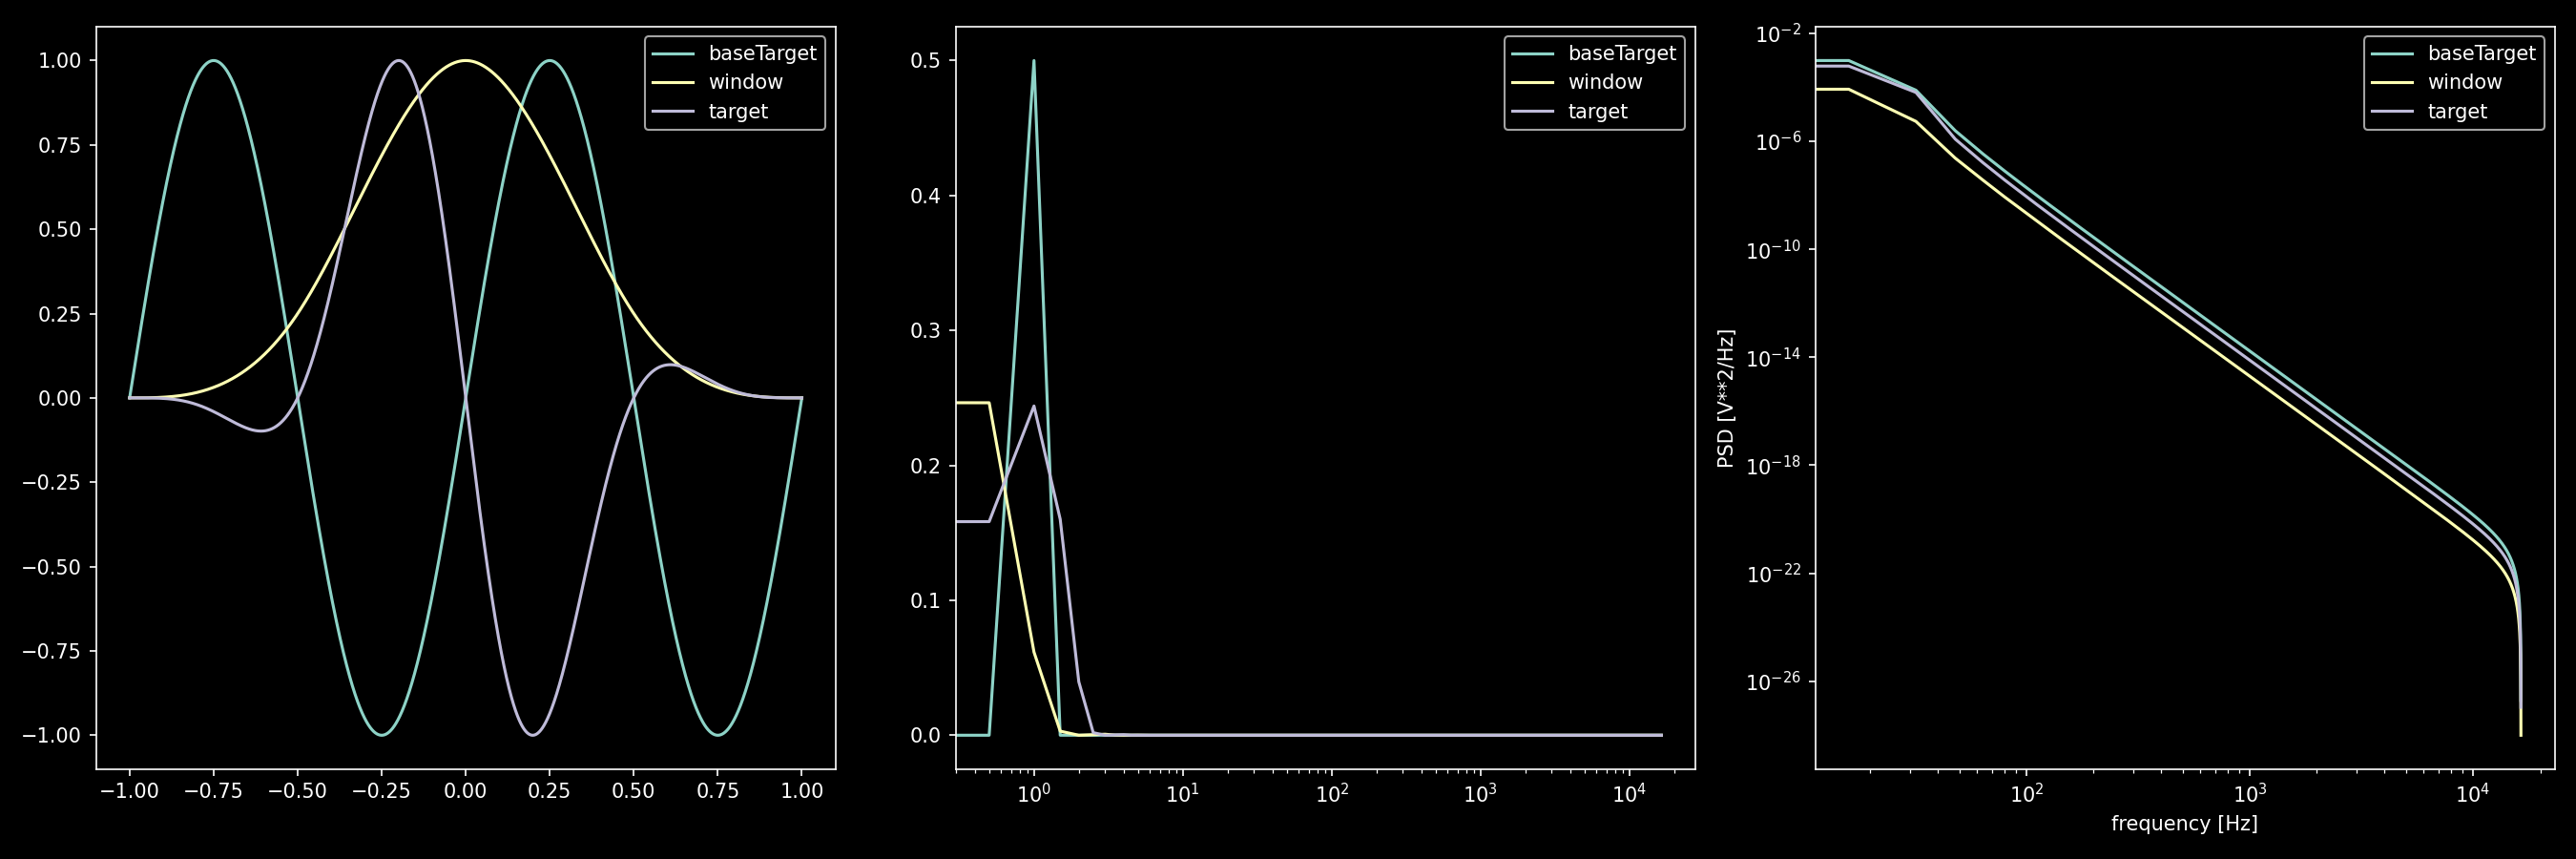

In [710]:
target = generateTargetFunction(freq = 1, octaves = 8, seed = 1234, r = 1 / (2 * np.pi), persistence = 0.85, numSamples = 2**16, \
                                normalized = True, periodicNoise = True, window = 'cubicSpline', baseOverride = lambda x: np.sin(2 * np.pi * x), plot = True)    

/tmp/ipykernel_1133728/3329294234.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  windowFn = lambda x : windowFunc(torch.abs(torch.tensor(x))).numpy()


<IPython.core.display.Javascript object>


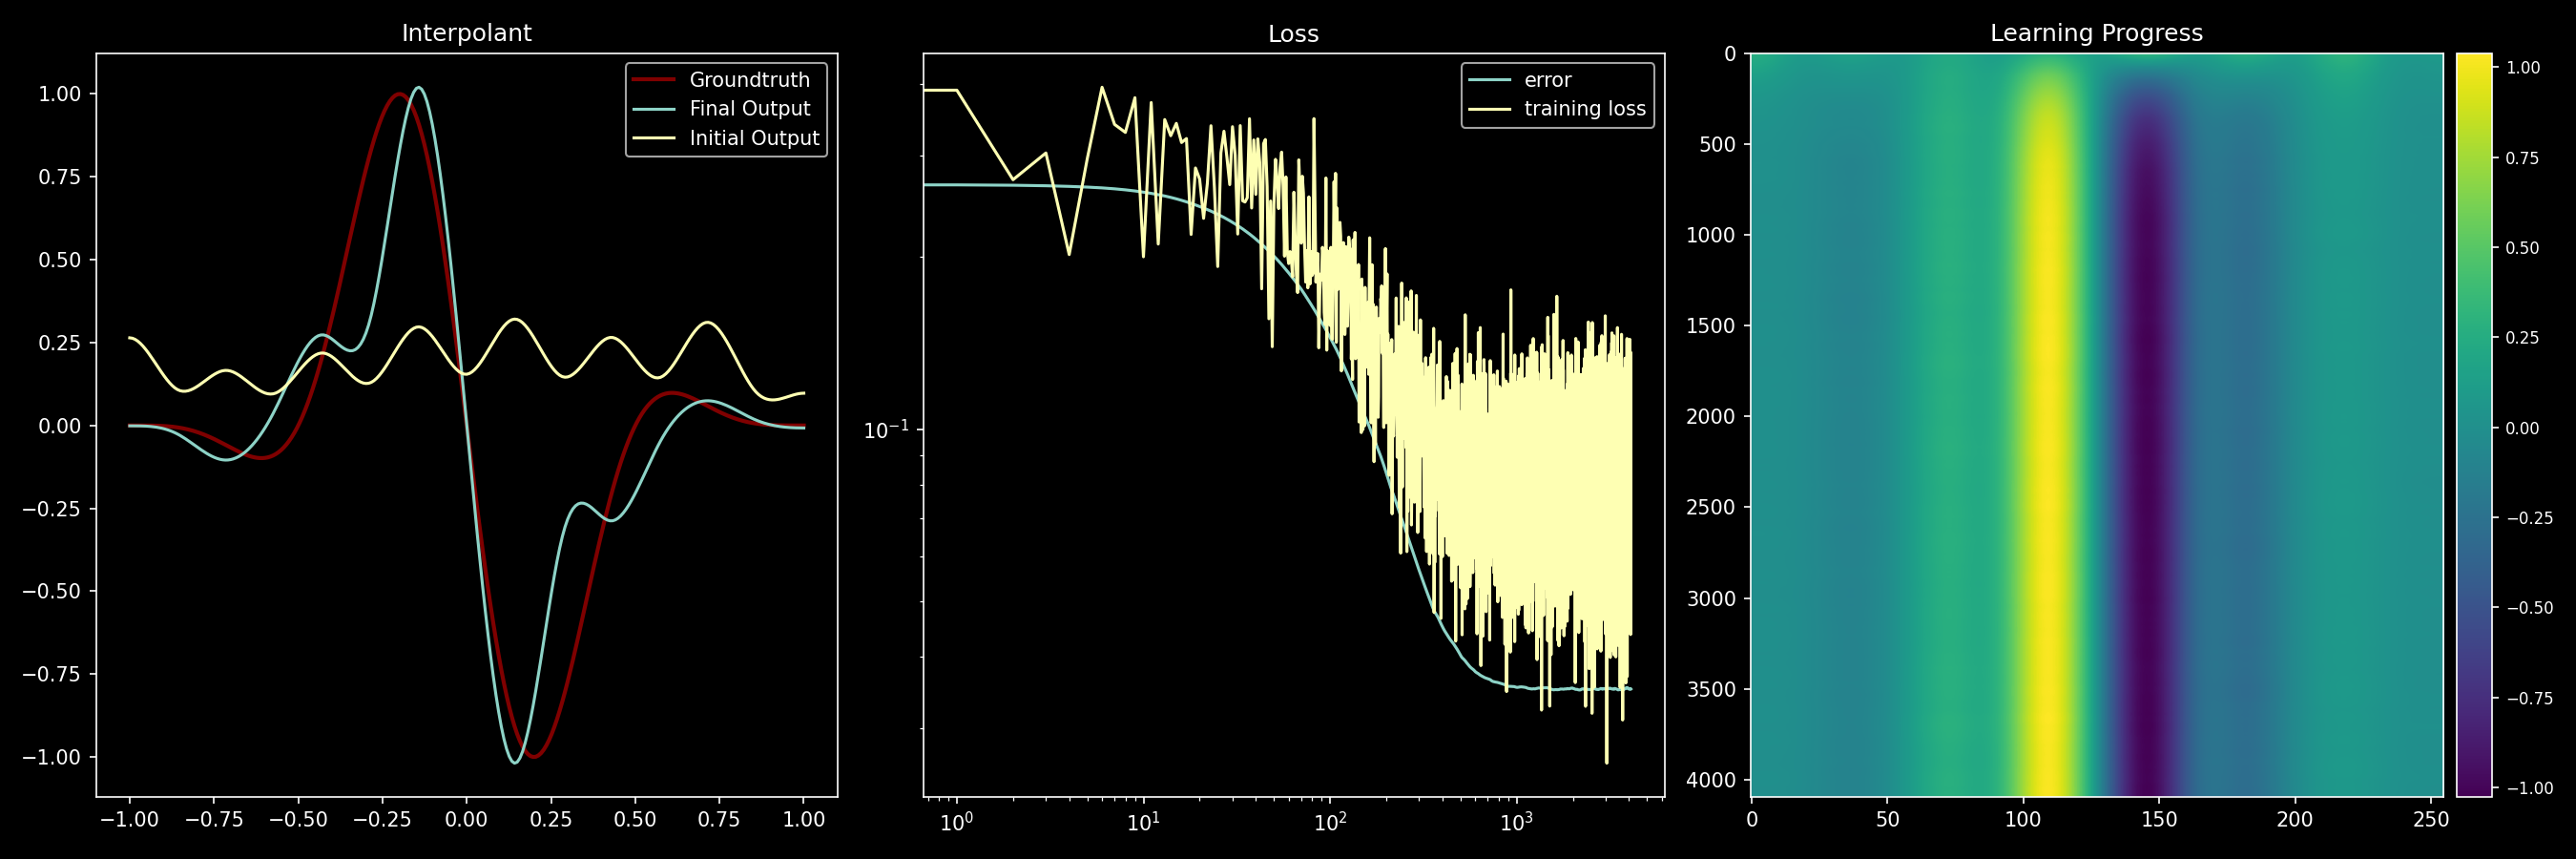

In [728]:
n = 8
basis = 'rbf cubic_spline 2'
basis = 'rbf cubic_spline'
normalizedBasis = False
samples = 1024
batch_size = 4


dataset = torch.vstack(sample(n, 1024, method = 'centered', dxScale = 4, dx = 1/3, clamped = True, seed = None))
groundTruth = evalGroundTruth(samples, dataset, target, noise = True, noiseType = 'normal', noiseVar = 0.25)
# print(dataset[0].shape)
# print(groundTruth[0].shape)
# plotDatasetAndGroundtruth(dataset, samples, target, groundTruth)
train_dataloader, train_iter = generateLoaders(torch.hstack((dataset,groundTruth)), batch_size = 4, shuffleDataset = True, shuffled = False, shuffleSeed = None)

weights = torch.rand(n)
weights.requires_grad = True
optimizer = optim.SGD([weights], lr=1e-2, momentum=0.9)

weightList = []
gradList = []
lossList = []
weightList.append(torch.clone(weights.detach()))

for i in range(4096):
    optimizer.zero_grad()
    
    sampled = sampleDataLoader()
#     print(sampled.shape)
    x = sampled[:,:sampled.shape[1]//2].flatten()
    gt = sampled[:,sampled.shape[1]//2:].flatten()
#     print(x.shape)
    
    fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis)    
    loss = torch.mean((torch.sum(weights[:,None] * fx, axis=0) - gt)**2)
    loss.backward()
    lossList.append(torch.clone(loss.detach()))

    gradList.append(torch.clone(weights.grad.detach()))
    optimizer.step()
    weightList.append(torch.clone(weights))
    
plotTrainingv3(n, basis, normalizedBasis, target, weightList, gradList, lossList, plotInterval = 32)